# Visualizing the different classes after dimension reduction

- PCA to bring down to 50
- t-sne for 2D visualization

In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
from lib import data_prep, feature_extraction
from sklearn.utils import shuffle
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

font = {
    "family": "sans-serif",
    "weight": "bold",
    "size": 16
}
matplotlib.rc("font", **font)

In [2]:
# Base directory
data_loc = os.path.join(os.getcwd(), "DATA")

# file name
file_names = {
    0: "machine_ON_no-ref_start-error_1.csv",  # Machine turned ON, and the parameter switch enable error
    1: "machine_ON_no-ref_start-error_2.csv",
    2: "machine_ON_no-ref_start-error_3.csv",
    3: "machine_ON_no-ref_start-error_4.csv",
    4: "machine_ON_ref_no-error_1.csv",  # Machine ON referenced and no-error idling
    5: "machine_ON_ref_no-error_2.csv",  # Machine ON referenced and no-error idling
    6: "machine_ON_ref_no-error_3.csv",
    7: "machine_ON_ref_no-error_4.csv",
    8: "machine_ON_ref_no-error_5.csv",
    9: "machine_ON_ref_no-error_6.csv",
    10: "machine_ON_ref_no-error_7.csv",
    11: "machine_ON_ref_no-error_8.csv",
    12: "machine_ON_ref_no-error_9.csv",
    13: "machine_ON_ref_no-error_10.csv",
    14: "machine_ON_ref_no-error_11.csv",
    15: "machine_ON_ref_no-error_12.csv",
    16: "machine_ON_ref_no-error_13.csv",
    17: "machine_ON_ref_overtravel-error_x_neg_1.csv",  # Machine ON referenced and Overtravel for X negative
    18: "machine_ON_ref_overtravel-error_x_pos_1.csv",  # Machine ON referenced and Overtravel for X positive
    19: "machine_ON_no-ref_overtravel-error_x_neg_1.csv",  # Machine ON not-referenced and Overtravel for X negative
    20: "machine_ON_no-ref_overtravel-error_x_pos_1.csv", # Machine ON not-referenced and Overtravel for X positive
    21: "machine_ON_ref_overtravel-error_x_neg_axes-extreme_1.csv", # Reference and overtravel in X
    22: "machine_ON_ref_overtravel-error_x_neg_axes-extreme_2.csv", # Referenced and overtravel in X
    23: "machine_ON_ref_overtravel-error_x_pos_axes-extreme_1.csv", # Referenced and overtravel in X
    24: "machine_ON_ref_overtravel-error_y_neg_axes-extreme_1.csv",  # Machine ON referenced and Overtravel for Y negative
    25: "machine_ON_ref_overtravel-error_y_neg_1.csv", # Machine and ON referenced and Overtravel in Y
    26: "machine_ON_ref_overtravel-error_y_pos_1.csv",  # Machine ON referenced and Overtravel for Y positive
    27: "machine_ON_ref_overtravel-error_y_pos_axes-extreme_1.csv",
    28: "machine_ON_ref_overtravel-error_z_neg_1.csv",  # Machine ON referenced and Overtravel for Z negative
    29: "machine_ON_ref_overtravel-error_z_neg_axes-extreme_1.csv",
    30: "machine_ON_ref_overtravel-error_z_pos_1.csv",  # Machine ON referenced and Overtravel for Z positive
    31: "machine_ON_ref_overtravel-error_z_pos_axes-extreme_1.csv",
    32: "machine_ON_no-ref_1.csv",
    33: "machine_ON_no-ref_2.csv"
}

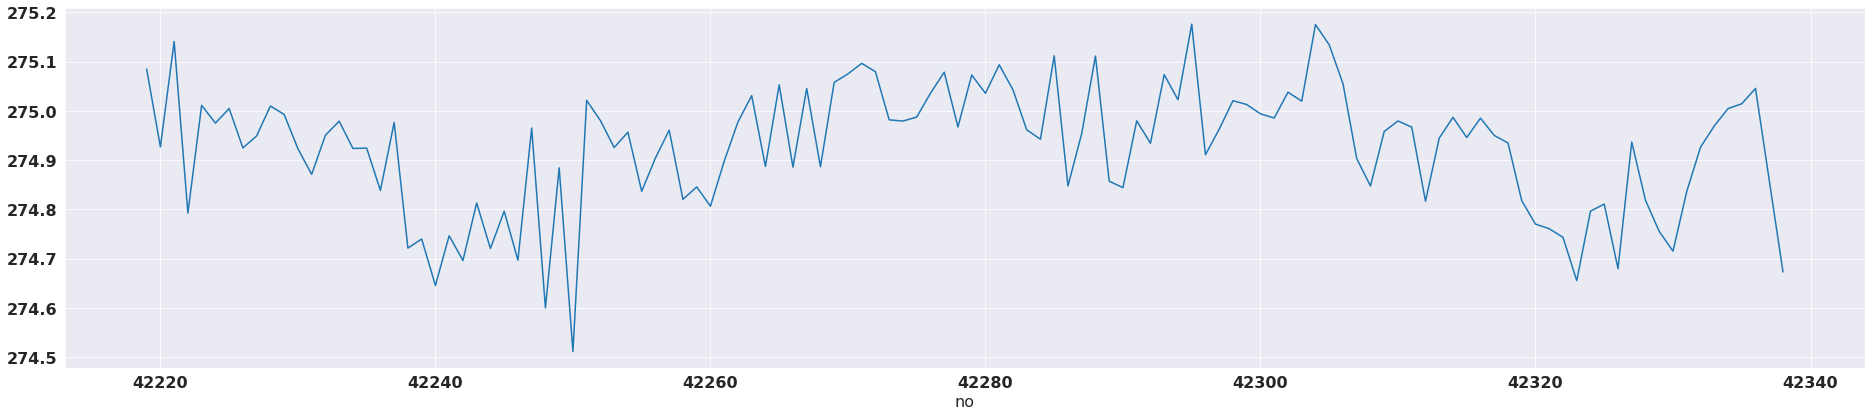

In [3]:
# load the data
index = 5
df = pd.read_csv(os.path.join(data_loc, file_names[index]), header="infer", index_col="no")
fig = plt.figure(figsize=(25, 5))
axs = fig.add_axes([0, 0, 1, 1])
df["PowerSum"][-120:].plot(ax=axs)

## Data preparation

- Segmentation
- Feature extraction

### Load the files

In [4]:
segment_secs = 60
wavelet_nperseg = 15
overlap_rate = 0.0

In [5]:
# Dont choose "no" and "sample_time" as they will be added later to the beginning
# Chosen - Three different power components for three phases
chosen_cols = ["Power1", "Power2", "Power3", "PowerReac1", "PowerReac2", "PowerReac3", "PowerApp1", "PowerApp2", "PowerApp3"]
segmented_data = {}
for index, file_name in file_names.items():
    path = os.path.join(data_loc, file_name)
    temp = data_prep.segment_data(file_name=path, col_names=chosen_cols, segment_secs=segment_secs, overlap_rate=overlap_rate)
    # Remove the sample_time col
    temp = temp[:, 1:, :]
    segmented_data[file_name] =  temp

In [6]:
# Print to ensure that segmentation is successful
for file_name in segmented_data.keys():

    sys.stdout.write(f"For the file-{file_name} the shape-{segmented_data[file_name].shape}\n")

For the file-machine_ON_no-ref_start-error_1.csv the shape-(60, 9, 19)
For the file-machine_ON_no-ref_start-error_2.csv the shape-(60, 9, 106)
For the file-machine_ON_no-ref_start-error_3.csv the shape-(60, 9, 859)
For the file-machine_ON_no-ref_start-error_4.csv the shape-(60, 9, 5054)
For the file-machine_ON_ref_no-error_1.csv the shape-(60, 9, 243)
For the file-machine_ON_ref_no-error_2.csv the shape-(60, 9, 705)
For the file-machine_ON_ref_no-error_3.csv the shape-(60, 9, 162)
For the file-machine_ON_ref_no-error_4.csv the shape-(60, 9, 1129)
For the file-machine_ON_ref_no-error_5.csv the shape-(60, 9, 338)
For the file-machine_ON_ref_no-error_6.csv the shape-(60, 9, 1436)
For the file-machine_ON_ref_no-error_7.csv the shape-(60, 9, 4926)
For the file-machine_ON_ref_no-error_8.csv the shape-(60, 9, 2052)
For the file-machine_ON_ref_no-error_9.csv the shape-(60, 9, 3233)
For the file-machine_ON_ref_no-error_10.csv the shape-(60, 9, 1231)
For the file-machine_ON_ref_no-error_11.csv t

### Determine classes

In [7]:
# Associations between the classes and the files in this study
# TODO: Separate the no-ref ON no-error class into a separate one?
class_file_association = {
    "on-ref": ["machine_ON_ref_no-error_1.csv", "machine_ON_ref_no-error_2.csv", "machine_ON_ref_no-error_3.csv", "machine_ON_ref_no-error_4.csv", "machine_ON_ref_no-error_5.csv", "machine_ON_ref_no-error_6.csv", "machine_ON_ref_no-error_7.csv", "machine_ON_ref_no-error_8.csv", "machine_ON_ref_no-error_9.csv", "machine_ON_ref_no-error_10.csv",
               "machine_ON_ref_no-error_11.csv", "machine_ON_ref_no-error_12.csv", "machine_ON_ref_no-error_13.csv"],# "machine_ON_no-ref_1.csv", "machine_ON_no-ref_2.csv"],

    "on-noref-error": ["machine_ON_no-ref_start-error_1.csv", "machine_ON_no-ref_start-error_2.csv", "machine_ON_no-ref_start-error_3.csv", "machine_ON_no-ref_start-error_4.csv"],

    "overtravel-x": ["machine_ON_ref_overtravel-error_x_neg_1.csv", "machine_ON_ref_overtravel-error_x_pos_1.csv", "machine_ON_no-ref_overtravel-error_x_neg_1.csv", "machine_ON_no-ref_overtravel-error_x_pos_1.csv", "machine_ON_ref_overtravel-error_x_neg_axes-extreme_1.csv",
    "machine_ON_ref_overtravel-error_x_neg_axes-extreme_2.csv", "machine_ON_ref_overtravel-error_x_pos_axes-extreme_1.csv"],

    "overtravel-y": ["machine_ON_ref_overtravel-error_y_neg_1.csv", "machine_ON_ref_overtravel-error_y_pos_1.csv",
                    "machine_ON_ref_overtravel-error_y_neg_axes-extreme_1.csv", "machine_ON_ref_overtravel-error_y_pos_axes-extreme_1.csv"],

    "overtravel-z": ["machine_ON_ref_overtravel-error_z_neg_1.csv", "machine_ON_ref_overtravel-error_z_pos_1.csv", "machine_ON_ref_overtravel-error_z_neg_axes-extreme_1.csv"] # , "machine_ON_ref_overtravel-error_z_pos_axes-extreme_1.csv"],
}

In [8]:
# Okay
class_segmented_data = {}
for class_instance in class_file_association.keys():
    for index, file_name in enumerate(class_file_association[class_instance]):

        if index == 0:
            class_segmented_data[class_instance] = segmented_data[file_name]
        else:
            class_segmented_data[class_instance] = np.append(class_segmented_data[class_instance], segmented_data[file_name], axis=-1)

In [9]:
# Reshape the data appropriately
for class_instance in class_segmented_data.keys():
    class_segmented_data[class_instance] = np.transpose(class_segmented_data[class_instance], (2, 1, 0))

In [10]:
# Print to ensure that the files have been loaded correctly
for class_instance in class_segmented_data.keys():

    sys.stdout.write(f"The class-{class_instance} has the shape-{class_segmented_data[class_instance].shape}\n")

The class-on-ref has the shape-(21111, 9, 60)
The class-on-noref-error has the shape-(6038, 9, 60)
The class-overtravel-x has the shape-(3469, 9, 60)
The class-overtravel-y has the shape-(2500, 9, 60)
The class-overtravel-z has the shape-(5130, 9, 60)


### Extract features

In [11]:
class_dataset_features = {}
for class_instance in class_segmented_data.keys():
    dataset_features = []
    for row in class_segmented_data[class_instance]:
        computed_features = []
        for col in row:
            freq_args = [{"axis": 0}, {"axis": 0}, {"axis": 0, "nperseg": wavelet_nperseg}]
            freq_time_args = [{"wavelet": "db1"}, {"wavelet": "db1"}, {"wavelet": "db1"}]
            # Concat features
            computed_features += feature_extraction.compute_all_features(col, freq_args=freq_args, freq_time_args=freq_time_args)

        # Append to a list
        dataset_features.append(computed_features)

    # Add to class instance
    class_dataset_features[class_instance] = np.array(dataset_features)

In [12]:
sys.stdout.write("After feature extraction process\n\n")
for class_instance in class_dataset_features.keys():

    sys.stdout.write(f'For the class-{class_instance} , the extracted features has the shape={class_dataset_features[class_instance].shape}\n')

After feature extraction process

For the class-on-ref , the extracted features has the shape=(21111, 153)
For the class-on-noref-error , the extracted features has the shape=(6038, 153)
For the class-overtravel-x , the extracted features has the shape=(3469, 153)
For the class-overtravel-y , the extracted features has the shape=(2500, 153)
For the class-overtravel-z , the extracted features has the shape=(5130, 153)


### Generate training

In [13]:
class_label_associations = {
    "on-ref": 0,
    "on-noref-error": 1,
    "overtravel-x": 2,
    "overtravel-y": 3,
    "overtravel-z": 4,
}
for index, class_instance in enumerate(class_dataset_features.keys()):

    temp_X = class_dataset_features[class_instance]
    temp_y = np.repeat(class_label_associations[class_instance], temp_X.shape[0])[:, np.newaxis]

    if index == 0:
        X = temp_X
        y = temp_y
    else:
        X = np.append(X, temp_X, axis=0)
        y = np.append(y, temp_y, axis=0)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)
# To a vector format
y =  np.squeeze(y)

sys.stdout.write(f"The final combined shape-{X.shape}\n")

The final combined shape-(38248, 153)


### Data Augmentation - by oversampling
- Oversample the normal scenario using SMOTE

In [14]:
# from imblearn.over_sampling import SMOTE
#
# sm = SMOTE(random_state=42, sampling_strategy={0: 40000})
# X, y = sm.fit_resample(X, y)
#
# print(f"The shape after resampling the majority class - {X.shape}")

### Standardize

In [15]:
# Apply StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

## Dimension Reduction

- Using PCA to number of components to 50

In [16]:
# Get the object
pca = PCA(n_components=50, svd_solver="full")
# Fit and transform data
X_pca = pca.fit_transform(X)

## Visualization

After a another dimension reduction

In [17]:
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=24, n_iter=10000, n_iter_without_progress=1000, init="pca", verbose=1, learning_rate="auto")
# Fit and transform
X_tnse = tsne.fit_transform(X_pca)

/home/vselvaraj/software_installations/anaconda3/envs/machinelearning/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38248 samples in 0.001s...
[t-SNE] Computed neighbors for 38248 samples in 24.780s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38248
[t-SNE] Computed conditional probabilities for sample 2000 / 38248
[t-SNE] Computed conditional probabilities for sample 3000 / 38248
[t-SNE] Computed conditional probabilities for sample 4000 / 38248
[t-SNE] Computed conditional probabilities for sample 5000 / 38248
[t-SNE] Computed conditional probabilities for sample 6000 / 38248
[t-SNE] Computed conditional probabilities for sample 7000 / 38248
[t-SNE] Computed conditional probabilities for sample 8000 / 38248
[t-SNE] Computed conditional probabilities for sample 9000 / 38248
[t-SNE] Computed conditional probabilities for sample 10000 / 38248
[t-SNE] Computed conditional probabilities for sample 11000 / 38248
[t-SNE] Computed conditional probabilities for sample 12000 / 38248
[t-SNE] Computed conditional probabilities for sa

/home/vselvaraj/software_installations/anaconda3/envs/machinelearning/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 207.226562
[t-SNE] KL divergence after 10000 iterations: 2.668321


Text(0.5, 1.0, 't-sne visualization')

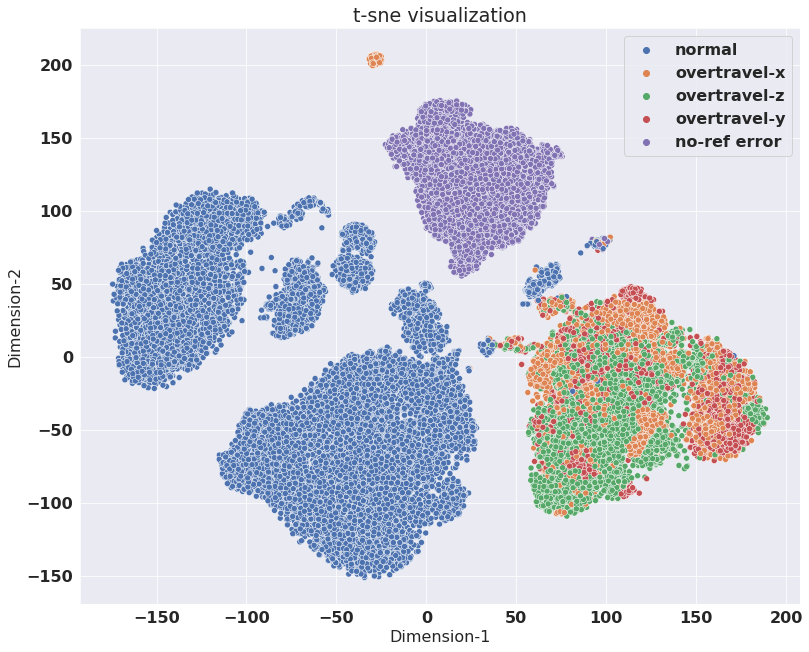

In [18]:
# Modify y
label_names = {0: "normal", 1: "no-ref error", 2: "overtravel-x", 3: "overtravel-y", 4: "overtravel-z"}
y_str = [label_names[x] for x in y]

# Scatterplot
fig = plt.figure(figsize=(10, 8))
axs = fig.add_axes([0, 0, 1, 1])

# Convert to df
X_tnse_df = pd.DataFrame(X_tnse, columns=["D1", "D2"])
sns.scatterplot(x='D1', y="D2", hue=y_str, data=X_tnse_df, ax=axs, palette="deep")
# Modify labels
axs.set_xlabel("Dimension-1")
axs.set_ylabel("Dimension-2")
axs.set_title("t-sne visualization")

- Differentiating the overtravels seems to be a difficult task and it would potentially need more data to achieve that.
- The class "normal" and class "no-ref error" seems to have very distinct pattern that can be easily seperated.
- Maybe more data on the overtravel instances might help?